In [23]:
from matplotlib import pyplot as plt
from tabulate import tabulate
import numpy as np
import cv2

In [24]:
# Steps

N = 256
G = 32
P = 48
D = 0.5

T_STEP = int(P / 10) + 1
I_STEP = int(N / 20) + 1

%run -i ./ownlib/PHT-Library3.ipynb
%run -i ./ownlib/RIW-Library3.ipynb
%run -i ./ownlib/Utility.ipynb
%run -i ./ownlib/Inverse-Geometric.ipynb

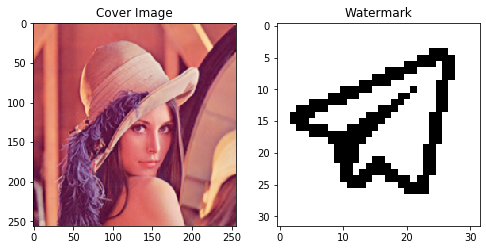

In [25]:
# Import images
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/paperplane.png', 0)

n = N
p = P
g = G
d = D

# Preprocess Image
IMG_BGR = cv2.resize(ori_img, (n, n)) # Original Image
IMG_Y = getYFromBGR(IMG_BGR) #

# Preprocess Logo
LOGO = cv2.resize(ori_logo, (g,g))
LOGO = (LOGO >= 128) * 1

imgshow([[IMG_BGR, LOGO]], [['Cover Image', 'Watermark']])

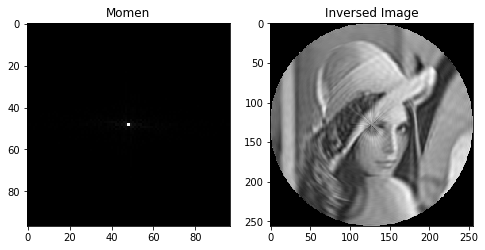

In [26]:
# Transform
MOMEN = transformPHT(IMG_Y, n, p, 'Transform Image, N={} G={} P={} D={}'.format(n, g, p, d))
IMG_Y_INVERSED = inversePHT(MOMEN, n, p, 'Inverse Image, N={} G={} P={} D={}'.format(n, g, p, d))

clear_output(wait = True)
imgshow([[MOMEN, IMG_Y_INVERSED]], [['Momen', 'Inversed Image']])

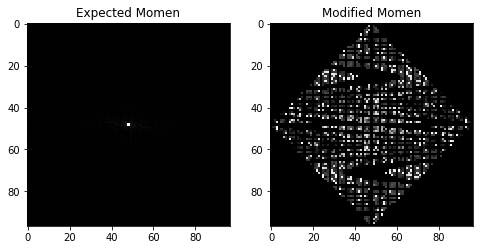

In [27]:
%run -i ./ownlib/RIW-Library3.ipynb

# Embedding
(LOGO_POSITIONED, LOGO_FILTER, maxCapacity) = watermarkEmbed(LOGO, p)

MOMEN_EXPECTED = 2 * d * np.round(np.abs(MOMEN) / 2 / d)
MOMEN_EXPECTED = MOMEN_EXPECTED + d / 2 * (LOGO_POSITIONED == 1)
MOMEN_EXPECTED = MOMEN_EXPECTED - d / 2 * (LOGO_POSITIONED == 0)
MOMEN_EXPECTED = MOMEN_EXPECTED + 2 * d * (MOMEN_EXPECTED < 0)

MOMEN_DIFF = MOMEN_EXPECTED - np.abs(MOMEN)
MOMEN_DIFF = MOMEN_DIFF / (np.abs(MOMEN) + 0.000000001) * MOMEN

OMEGA = MOMEN_DIFF * LOGO_FILTER

clear_output(wait = True)
imgshow([[MOMEN_EXPECTED, OMEGA]], [['Expected Momen', 'Modified Momen']])

In [28]:
# imgshow1(MOMEN_DIFF, 'Compensation Image')
np.max(MOMEN_DIFF), np.min(MOMEN_DIFF)

((0.7406135347612034+0.0706079144549906j),
 (-0.7292060418479036-0.06086404810320227j))

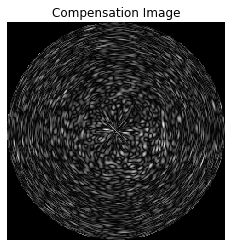

In [29]:
# Compensation Image
IMG_COMPENSATION = inversePHT(OMEGA, n, p, 'Generating Compensation Image N={} G={} P={} D={}'.format(n, g, p, d))

clear_output(wait = True)
imgshow1(IMG_COMPENSATION, 'Compensation Image')

In [30]:
np.min(IMG_COMPENSATION), np.max(IMG_COMPENSATION)

((-56.12365526505121-1.2993078835066285e-15j),
 (69.78838635786647+1.5985476831126277e-15j))

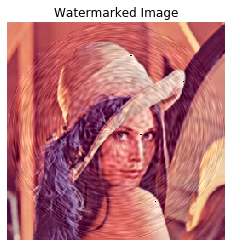

In [31]:
# Watermarking
# IMG_Y_WATERMARKED = IMG_Y + np.max(IMG_Y) * IMG_COMPENSATION / np.max(np.abs(IMG_Y_INVERSED))
IMG_Y_WATERMARKED = IMG_Y + IMG_COMPENSATION
IMG_WATERMARKED = putYToBGR(IMG_Y_WATERMARKED, IMG_BGR)

clear_output(wait = True)
imgshow1(IMG_WATERMARKED, 'Watermarked Image')

In [32]:
# Calculate PSNR
MSE = np.mean((IMG_WATERMARKED - IMG_BGR) ** 2)
PSNR = 10 * np.log10(255 * 255 / MSE)

print(tabulate([[n, g, p, d, PSNR]], headers=['N', 'G', 'P', 'D', 'PSNR'], tablefmt='orgtbl'))

|   N |   G |   P |   D |   PSNR |
|-----+-----+-----+-----+--------|
| 256 |  32 |  48 | 0.5 | 30.371 |


In [33]:
def war(image, n):
    attackedImages = []
    
    # No Attack
    attackedImages.append((np.copy(image), 'No Attack'))
    
    # Attack: Rotation
    ROTATION_ANGLE = 45
    imgRotate = attackRotation(image, ROTATION_ANGLE)
    attackedImages.append((imgRotate, 'Rotation {}° CW'.format(ROTATION_ANGLE)))
    
    # Attack: Scaling
    RESIZE_FACTOR = 0.75
    imgResize = attackResize(image, int(RESIZE_FACTOR * n))
    attackedImages.append((imgResize, 'Scaling ' + '{:.0%}'.format(RESIZE_FACTOR)))
    
    # Attack: Translation
    TR_X = 0.05
    TR_Y = -0.05
    imgTranslate = attackTranslate(image, TR_X, TR_Y)
    attackedImages.append((imgTranslate, 'Translation X={:.0%} Y={:.0%}'.format(TR_X, TR_Y)))
    
    # Attack: Crop
    CROP_PERCENTAGE = 0.05
    imgCrop = attackCrop(image, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE)
    attackedImages.append((imgCrop, 'Crop {:.0%}'.format(CROP_PERCENTAGE)))
    
    # Attack: BLUR
    BLUR_KERNEL_SIZE = 3
    imgBlur = attackBlur(image, BLUR_KERNEL_SIZE)
    attackedImages.append((imgBlur, 'Blur K={}'.format(BLUR_KERNEL_SIZE)))

    # Attack: Black & Pepper Noise
    NOISE_PERCENTAGE = 0.05
    imgNoise = attackRandomNoise(image, NOISE_PERCENTAGE)
    attackedImages.append((imgNoise, 'Noise {:.0%}'.format(NOISE_PERCENTAGE)))

    # Attack: JPG Compression
    COMPRESSION_QUALITY = 60
    imgJpg = attackJPG(image, ROTATION_ANGLE)
    attackedImages.append((imgJpg, 'JPG Compression Q={}'.format(COMPRESSION_QUALITY)))
    
    return attackedImages

extractedLogos = [None]*20
extractedBers = [None]*20
attackedImages = [None]*20
attackTitles = [None]*20

In [34]:
imgAttackedList = war(IMG_WATERMARKED, n)

In [35]:
def extractWatermarkFromImage2(img, ori_img, ori_logo, n, g, p, d, message=''):
    ori_img = cv2.resize(ori_img, (n, n))
    ori_logo = (cv2.resize(ori_logo, (g, g)) >= 128) * 1
    used_img = cv2.resize(img, (n, n))
    
    # Reverse Translation
    (h, w, c) = used_img.shape
    cx = (h - 1) / 2
    (tx, ty) = correctTranslate(ori_img, used_img, (cx, cx))
    used_img = attackTranslateByPixel(used_img, tx, ty)
    
    imgY = getYFromBGR(used_img)
    
    # Calculate Momen
    (n, _) = imgY.shape
    momen = transformPHT(imgY, n, p, message)
    
    # Current Binary Value & Difference
    QQ = ((np.abs(momen) - 2 * d * np.round(np.abs(momen) / 2 / d)) > 0) * 1
    
    # Crop Watermark
    extractedLogo = watermarkExtract(QQ, p, g) # MAT_Q_MODIFIED[logo_position]
    
    # Calculate Bit Error Rate    
    be = calcBE(ori_logo, extractedLogo)
    ber = be / (g * g)
    
    return (extractedLogo, ber)

BER = 0.00%


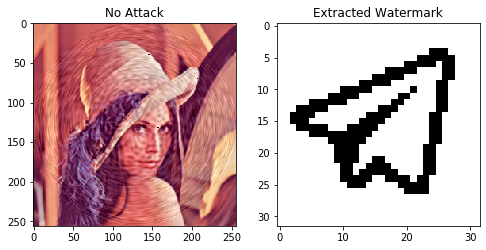

In [36]:
index = 0
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage2(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.2%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 5%


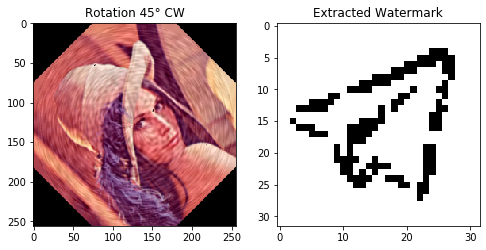

In [37]:
index = 1
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage2(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 7%


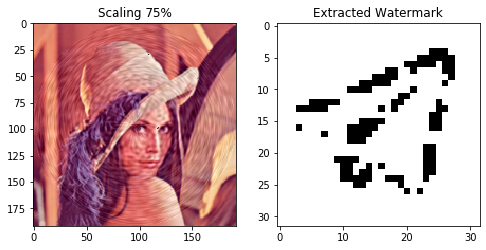

In [38]:
index = 2
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage2(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 6%


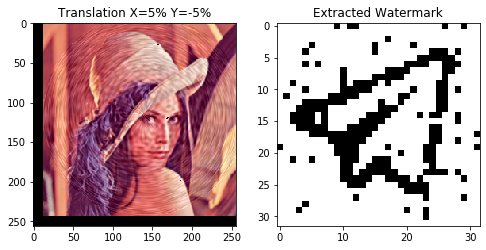

In [39]:
index = 3
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage2(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 2%


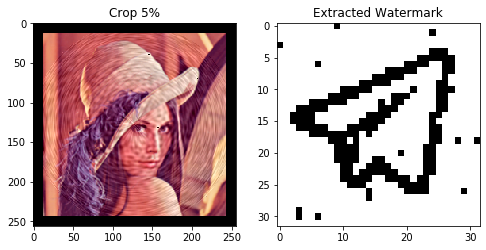

In [40]:
index = 4
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage2(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 9%


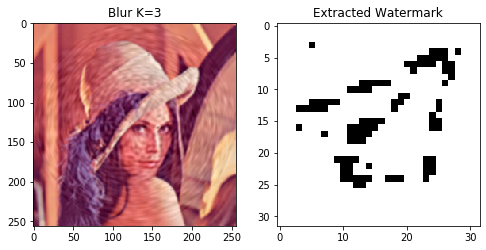

In [41]:
index = 5
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage2(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 3%


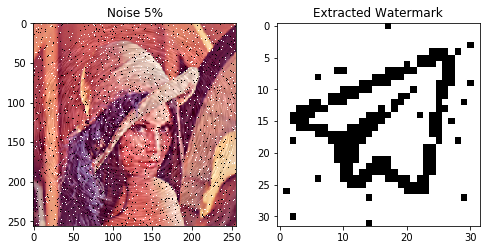

In [42]:
index = 6
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage2(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

BER = 2%


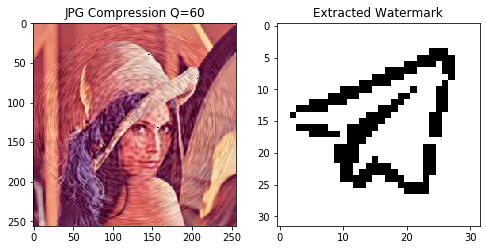

In [43]:
index = 7
(attackedImages[index], attackTitles[index]) = imgAttackedList[index]
(extractedLogos[index], extractedBers[index]) = extractWatermarkFromImage2(attackedImages[index], ori_img, ori_logo, n, g, p, d, 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, attackTitles[index]))

clear_output(wait = True)
print('BER = {:.0%}'.format(extractedBers[index]))
imgshow([[attackedImages[index], extractedLogos[index]]], [[attackTitles[index], 'Extracted Watermark']])

In [44]:
print(tabulate(
    [
        attackTitles[0:8],
        list(map(lambda x: '{:.0%}'.format(x), extractedBers[0:8]))
    ],
    tablefmt='orgtbl'
))

| No Attack | Rotation 45° CW | Scaling 75% | Translation X=5% Y=-5% | Crop 5% | Blur K=3 | Noise 5% | JPG Compression Q=60 |
| 0%        | 5%              | 7%          | 6%                     | 2%      | 9%       | 3%       | 2%                   |
